# IMG_4503

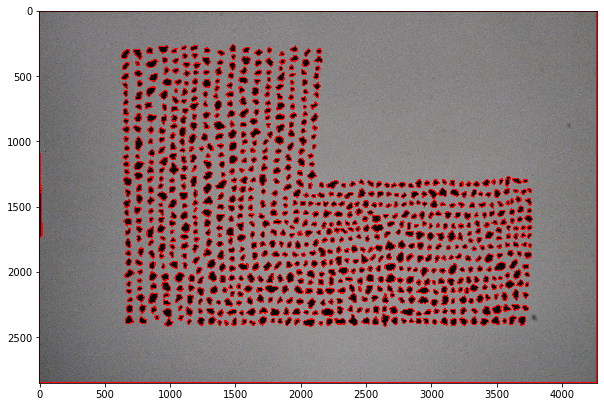

In [2]:
# -*- coding: utf-8 -*-
"""
Created on Tue Mar 17 17:38:06 2020

@author: sayaka71
"""

import numpy as np
import cv2
import matplotlib.pyplot as plt


# グラフ描画の関数定義
def display(img,cmap=None):
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111)
    ax.imshow(img,cmap=cmap)

# グレー画像
img = cv2.imread('grain.jpg')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)


# 大津法で2値化 retはbool値
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

# ノイズを消す
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)

# 確実な背景
sure_bg = cv2.dilate(opening,kernel,iterations=3)

# --- 距離変換　（オブジェクトと背景の距離を出す） ---
# 閾値（距離変換で得られた値の最大値×0.2） ←ここを調節！
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform, 0.2*dist_transform.max(), 255, 0)

# 距離変換の結果から確実な前景を
sure_fg = np.uint8(sure_fg)

# 前景でも後景でもないUnknown
unknown = cv2.subtract(sure_bg,sure_fg)


# オブジェクトごとにラベルをつける
ret, markers = cv2.connectedComponents(sure_fg)
markers = markers+1
markers[unknown==255] = 0

# markersデータをもとにwatershed
markers = cv2.watershed(img, markers)


contours, hierarchy = cv2.findContours(markers.copy(),cv2.RETR_CCOMP,cv2.CHAIN_APPROX_SIMPLE)

for i in range(len(contours)):
    
    if hierarchy[0][i][3] == -1:
        # 境界を赤色で描く  (255, 0,　0)： color red,  5pt line
        cv2.drawContours(img, contours, i, (255, 0, 0), 5)
 

display(img)

In [9]:
markers.shape

(2848, 4272)

In [10]:
img.shape

(2848, 4272, 3)

In [11]:
markers

array([[-1, -1, -1, ..., -1, -1, -1],
       [-1,  1,  1, ...,  1,  1, -1],
       [-1,  1,  1, ...,  1,  1, -1],
       ...,
       [-1,  1,  1, ...,  1,  1, -1],
       [-1,  1,  1, ...,  1,  1, -1],
       [-1, -1, -1, ..., -1, -1, -1]], dtype=int32)

In [16]:
# 粒子の形状を測定
Areas = []
Circularities = []
Eq_diameters = []

for i in contours:
    # 面積 (px*px)
    area = cv2.contourArea(i)
    Areas.append(area)
    
    # 円形度
    arc = cv2.arcLength(i, True)
    circularity = 4 * np.pi * area/(arc*arc)
    Circularities.append(circularity)
    
    # 等価直径(px)
    eq_diameter = np.sqrt(4 * area/np.pi)
    Eq_diameters.append(eq_diameter)
      

In [23]:
Areas[:3]

[514.5, 676.5, 896.0]

In [70]:
import pandas as pd
df = pd.DataFrame({'Areas(px^2)': Areas, 'Circularity': Circularities, 'Equal Diameters(px)': Eq_diameters})

In [71]:
df.head()

,Areas(px^2),Circularity,Equal Diameters(px)
0,514.5,0.801032,25.594565
1,676.5,0.830823,29.348706
2,896.0,0.599426,33.776066
3,1140.0,0.650784,38.098466
4,692.0,0.692205,29.683021


In [72]:
# 外れ値がある
df.describe()

,Areas(px^2),Circularity,Equal Diameters(px)
count,1.679000e+03,1679.000000,1679.000000
mean,8.780688e+03,0.740543,45.584202
std,2.961039e+05,0.053914,95.432824
min,4.355000e+02,0.045939,23.547735
25%,9.800000e+02,0.709536,35.323855
50%,1.326500e+03,0.745033,41.096864
75%,1.957500e+03,0.776870,49.923604
max,1.213455e+07,0.870617,3930.672428


In [73]:
# 外れ値をdrop
df.loc[df['Equal Diameters(px)'] > 2000]

,Areas(px^2),Circularity,Equal Diameters(px)
1678,12134547.5,0.746542,3930.672428


In [74]:
df.iloc[-1]

Areas(px^2)            1.213455e+07
Circularity            7.465418e-01
Equal Diameters(px)    3.930672e+03
Name: 1678, dtype: float64

In [77]:
df.drop(1678,axis=0, inplace=True)

In [78]:
df.describe()

,Areas(px^2),Circularity,Equal Diameters(px)
count,1678.000000,1678.000000,1678.000000
mean,1554.366806,0.740539,43.268893
std,774.714713,0.053930,10.341561
min,435.500000,0.045939,23.547735
25%,980.000000,0.709525,35.323855
50%,1326.250000,0.745029,41.092991
75%,1955.625000,0.776901,49.899686
max,9221.500000,0.870617,108.356719


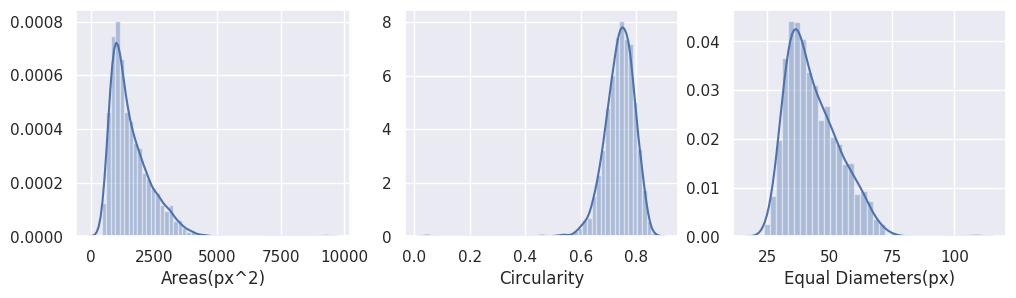

In [100]:
import seaborn as sns
sns.set()

fig, ax = plt.subplots(1,3,figsize=(12,3), dpi=100)

sns.distplot(df['Areas(px^2)'], ax=ax[0])
sns.distplot(df['Circularity'], ax=ax[1])
sns.distplot(df['Equal Diameters(px)'], ax=ax[2])